<a href="https://colab.research.google.com/github/takky0330/face/blob/master/OpenPose_face.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###OpenPose インストール

In [1]:
import os
from os.path import exists, join, basename, splitext

In [2]:
git_repo_url = 'https://github.com/CMU-Perceptual-Computing-Lab/openpose.git'
project_name = splitext(basename(git_repo_url))[0]
if not exists(project_name):
  # see: https://github.com/CMU-Perceptual-Computing-Lab/openpose/issues/949
  # install new CMake becaue of CUDA10
  !wget -q https://cmake.org/files/v3.13/cmake-3.13.0-Linux-x86_64.tar.gz
  !tar xfz cmake-3.13.0-Linux-x86_64.tar.gz --strip-components=1 -C /usr/local
  # clone openpose
  !git clone -q --depth 1 $git_repo_url
  !sed -i 's/execute_process(COMMAND git checkout master WORKING_DIRECTORY ${CMAKE_SOURCE_DIR}\/3rdparty\/caffe)/execute_process(COMMAND git checkout f019d0dfe86f49d1140961f8c7dec22130c83154 WORKING_DIRECTORY ${CMAKE_SOURCE_DIR}\/3rdparty\/caffe)/g' openpose/CMakeLists.txt
  # install system dependencies
  !apt-get -qq install -y libatlas-base-dev libprotobuf-dev libleveldb-dev libsnappy-dev libhdf5-serial-dev protobuf-compiler libgflags-dev libgoogle-glog-dev liblmdb-dev opencl-headers ocl-icd-opencl-dev libviennacl-dev
  # install python dependencies
  !pip install -q youtube-dl
  # build openpose
  !cd openpose && rm -rf build || true && mkdir build && cd build && cmake .. && make -j`nproc`
  

Selecting previously unselected package libgflags2.2.
(Reading database ... 144487 files and directories currently installed.)
Preparing to unpack .../00-libgflags2.2_2.2.1-1_amd64.deb ...
Unpacking libgflags2.2 (2.2.1-1) ...
Selecting previously unselected package libgflags-dev.
Preparing to unpack .../01-libgflags-dev_2.2.1-1_amd64.deb ...
Unpacking libgflags-dev (2.2.1-1) ...
Selecting previously unselected package libgoogle-glog0v5.
Preparing to unpack .../02-libgoogle-glog0v5_0.3.5-1_amd64.deb ...
Unpacking libgoogle-glog0v5 (0.3.5-1) ...
Selecting previously unselected package libgoogle-glog-dev.
Preparing to unpack .../03-libgoogle-glog-dev_0.3.5-1_amd64.deb ...
Unpacking libgoogle-glog-dev (0.3.5-1) ...
Selecting previously unselected package libhdf5-serial-dev.
Preparing to unpack .../04-libhdf5-serial-dev_1.10.0-patch1+docs-4_all.deb ...
Unpacking libhdf5-serial-dev (1.10.0-patch1+docs-4) ...
Selecting previously unselected package libleveldb1v5:amd64.
Preparing to unpack ...

###ファイルアップロード

In [6]:
import zipfile

In [ ]:
## 事前にアップロードファイルを削除する場合
#os.remove('202599.zip')

In [ ]:
## ローカルからアップロードする場合
from google.colab import files
import shutil
import zipfile
pic_dir = './pic/'
json_dir = './json/'

uploaded = files.upload()
uploaded_file = list(uploaded.keys())[0]
print(uploaded_file)

In [231]:
uploaded_file = '009999.zip'
## GoogleDriveからコピーする場合
from google.colab import drive
pic_dir = './pic/'
json_dir = './json/'

drive_dir = '/content/drive'
drive.mount(drive_dir)
import shutil
shutil.copyfile(drive_dir + '/My Drive/face_pic/' + uploaded_file, './' + uploaded_file)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


'./009999.zip'

In [232]:
_zip_dir = uploaded_file
zip_dir = _zip_dir.split('.')
zip_dir.pop(-1)
zip_dir = ''.join(zip_dir)

print(pic_dir + zip_dir)
if not os.path.exists(pic_dir + zip_dir):
    os.makedirs(pic_dir + zip_dir)
if not os.path.exists(json_dir + zip_dir):
    os.makedirs(json_dir + zip_dir)

with zipfile.ZipFile(uploaded_file) as existing_zip:
    existing_zip.extractall(pic_dir + zip_dir + '/')

os.remove(uploaded_file)

./pic/009999


In [234]:
! ls ./pic/009999 | wc -l

9999


### openPose 実行（画像）

In [235]:
import glob
import re
import subprocess

In [236]:
def open_pose(dir):
    current_dir       = '/content'
    change_dir       = '/openpose'
    openpose_path = './build/examples/openpose/openpose.bin'
    soruce_path     = '/content/pic/' + dir + '/'
    output_path     = '/content/json/' + dir + '/'
    res = -1
    print('soruce_path : ' + soruce_path)
    print('output_path : ' + output_path)

    #! cd openpose && ./build/examples/openpose/openpose.bin --video ../video.mp4 --write_json ./output/ --display 0  --write_video ../openpose.avi
    os.chdir(current_dir + change_dir)
    print(os.getcwd())
    print('処理画予定像数　：　' + str(len(list(glob.glob(soruce_path + '*.*')))))
    command = openpose_path + ' --image_dir ' + soruce_path + ' --write_json ' + output_path + ' --face --hand --display 0 --render_pose 0'
    print(command)
    res = subprocess.call(command, shell=True)
    print('処理済み画像数　：　' + str(len(list(glob.glob(output_path + '*.*')))))
    os.chdir(current_dir)
    return res
  

In [ ]:
res = open_pose(zip_dir)
print(res)

soruce_path : /content/pic/009999/
output_path : /content/json/009999/
/content/openpose
処理画予定像数　：　9999
./build/examples/openpose/openpose.bin --image_dir /content/pic/009999/ --write_json /content/json/009999/ --face --hand --display 0 --render_pose 0


### face 情報取得

In [186]:
def get_face(face_dir):
    face_list = {}
    brn_list = sorted(list(glob.glob(face_dir + '*.*')))
    for _brn in brn_list:
        kp_dict_part = [''] * 5
        with open(_brn, 'r') as json_open:
            keypoint = json.load(json_open)
        brn_name = re.split('\/', _brn).pop(-1)
        img_name = re.sub('_keypoints', '', re.split('\.', brn_name).pop(0)) + '.jpg'
        try:
            #face, eye, nose, mouth = gat_pose([keypoint['people'][0]['pose_keypoints_2d']])
            face, eye, nose, mouth = gat_face([keypoint['people'][0]['face_keypoints_2d']])
        except:
             print('エラー ： ' + img_name)
        kp_dict_part[0] = {'class': 'face', 'x1': int(face[0]), 'x2': int(face[2]), 'y1': int(face[1]), 'y2': int(face[3])}
        kp_dict_part[1] = {'class': 'eye', 'x1': int(eye[0][0]), 'x2': int(eye[0][2]), 'y1': int(eye[0][1]), 'y2': int(eye[0][3])}
        kp_dict_part[2] = {'class': 'eye', 'x1': int(eye[1][0]), 'x2': int(eye[1][2]), 'y1': int(eye[1][1]), 'y2': int(eye[1][3])}
        kp_dict_part[3] = {'class': 'nose', 'x1': int(nose[0]), 'x2': int(nose[2]), 'y1': int(nose[1]), 'y2': int(nose[3])}
        kp_dict_part[4] = {'class': 'mouth', 'x1': int(mouth[0]), 'x2': int(mouth[2]), 'y1': int(mouth[1]), 'y2': int(mouth[3])}
        
        face_list[img_name] = kp_dict_part

    return face_list

In [193]:
def gat_face(kp):
    x = 0
    y = 1
    r = 2
    if kp[0][33*3+x] < kp[0][0*3+x]:
        faceL = kp[0][33*3+x]; faceR = kp[0][16*3+x]
    elif kp[0][33*3+x] >= kp[0][16*3+x]:
        faceL = kp[0][0*3+x]; faceR = kp[0][33*3+x]
    else:
        faceL = kp[0][0*3+x]; faceR = kp[0][16*3+x]
    if kp[0][8*3+y] < kp[0][57*3+y]:
        faceT = kp[0][27*3+y] - (kp[0][57*3+y] + (kp[0][51*3+y] - kp[0][30*3+y]) - kp[0][27*3+y]); faceB = kp[0][57*3+y] + (kp[0][51*3+y] - kp[0][30*3+y])
    else:
        faceT = kp[0][27*3+y] - (kp[0][8*3+y] - kp[0][27*3+y]); faceB = kp[0][8*3+y]
    _w = (faceR - faceL) / 10.
    _h = (faceB - faceT) / 10.

    face   = [ faceL - _w , faceT - _h , faceR + _w , faceB + (_h/2.) ]
    eye = [[0,0,0,0], [0,0,0,0]]
    if kp[0][36*3+x] > 0.:
        eye[0] = [ kp[0][36*3+x] - (_w/2.) , kp[0][36*3+y] - (_h/2.) , kp[0][39*3+x] + (_w/2.) ,  kp[0][39*3+y] + (_h/2.) ]
    if kp[0][45*3+x] > 0.:
        eye[1] = [ kp[0][45*3+x] + (_w/2.) , kp[0][45*3+y] - (_h/2.) , kp[0][42*3+x] - (_w/2.) ,  kp[0][42*3+y] + (_h/2.) ]
    nose   = [ kp[0][31*3+x] - (_w/5.) ,  kp[0][27*3+y] - (_h/5.) ,  kp[0][35*3+x] + (_w/5.) ,  kp[0][33*3+y]  + (_h/5.) ]
    mouth  = [ kp[0][48*3+x] - (_w/5.) , kp[0][51*3+y] - (_h/5.) , kp[0][54*3+x] + (_w/5.) , kp[0][57*3+y] + (_h/5.)]

    return face, eye, nose, mouth

In [194]:
def gat_pose(kp):
    Nose = [kp[0][0*3], kp[0][0*3+1], 0.]
    Neck = (kp[0][1*3], kp[0][1*3+1])

    l_eye = (kp[0][14*3], kp[0][14*3+1])
    r_eye = (kp[0][15*3], kp[0][15*3+1])
    l_ear = (kp[0][16*3], kp[0][16*3+1])
    r_ear = (kp[0][17*3], kp[0][17*3+1])
    if kp[0][16*3+2] == 0.:                        # 左耳が見えない時、左耳は左目の値とする
        l_ear = (l_eye[0], r_ear[1])
        Nose[2] = ((l_ear[0] + r_ear[0]) / 2) - Nose[0]
    if kp[0][17*3+2] == 0.:                        # 右耳が見えない時は、右耳は右目の値とする
        r_ear = (r_eye[0], l_ear[1])
        Nose[2] = ((l_ear[0] + r_ear[0]) / 2 - Nose[0])
    _face_vert = Neck[1] - Nose[1]
    face_vert  = _face_vert * 1.2
    face_vert2 = face_vert / 2.
    face_vert3 = face_vert / 3.
    face_hori  = r_ear[0] - l_ear[0]
    face_hori2 = face_hori / 2. * 1.3
    _w = face_hori / 10.
    _h = face_vert / 10.
    
    eye = [''] * 2
    face   = [(Nose[0] - face_hori2) + Nose[2], Nose[1] - (face_vert2 + face_vert3), (Nose[0] + face_hori2) + Nose[2], Nose[1] + face_vert2]
    eye[0] = [l_eye[0]-(_w*1.5), l_eye[1]-_h, l_eye[0]+(_w*1.5), l_eye[1]+_h]
    eye[1] = [r_eye[0]-(_w*1.5), r_eye[1]-_h, r_eye[0]+(_w*1.5), r_eye[1]+_h]
    nose   = [Nose[0]-(_w*1.5), Nose[1]-(_h*2.5), Nose[0]+(_w*1.5), Nose[1]+(_h*1.)]
    mouth  = [Nose[0] + (Nose[2] / 2.) - (face_hori2 / 2.)
            , Nose[1] + (face_vert3 / 2.) - _h
            , Nose[0] + (Nose[2] / 2.) + (face_hori2 / 2.)
            , Nose[1] + (face_vert3 / 2.) + _h * 1.5]

    return face, eye, nose, mouth

In [195]:
import json
json_dir = '/content/drive/My Drive/face_json/'

face_dict = get_face('/content/json/' + zip_dir + '/')
with open(json_dir + 'celeba_' + zip_dir + '.json', 'w') as json_write:
    json.dump(face_dict, json_write)

エラー ： 200472.jpg


### 確認等

In [99]:
from PIL import Image as pilImage
from PIL import ImageDraw
from IPython.display import Image,display_jpeg
#display_jpeg(Image('/content/pic/202599/202599.jpg'))

In [144]:
def showImage(face_dict, img_dir, img_name):
    base_dir = '/content/pic/'
    face_dir = base_dir + img_dir + '/'
    with pilImage.open(face_dir + img_name) as _img:
        img = _img.convert("RGB")
    parts = {}
    for cls in face_dict[img_name]:
        CLS = cls['class']
        if cls['class'] == 'eye':
            CLS = 'eye1'
            if CLS in parts: CLS = 'eye2'
        parts[CLS] = (cls['x1'], cls['y1'], cls['x2'], cls['y2']) 
        print(CLS, end='')
        print(parts[CLS])
    draw = ImageDraw.Draw(img)
    draw.rectangle(parts['face'], outline=(255, 33, 33), width=3)
    draw.rectangle(parts['eye1'], outline=(255, 33, 33), width=3)
    draw.rectangle(parts['eye2'], outline=(255, 33, 33), width=3)
    draw.rectangle(parts['nose'], outline=(255, 33, 33), width=3)
    draw.rectangle(parts['mouth'], outline=(255, 33, 33), width=3)
    #img.show()
    displayImage(img)

In [145]:
def displayImage(img):
    img.save("display.jpg")
    display_jpeg(Image("display.jpg"))

face(512, 74, 830, 592)
eye1(555, 321, 632, 372)
eye2(750, 326, 671, 373)
nose(611, 336, 671, 446)
mouth(591, 454, 707, 510)


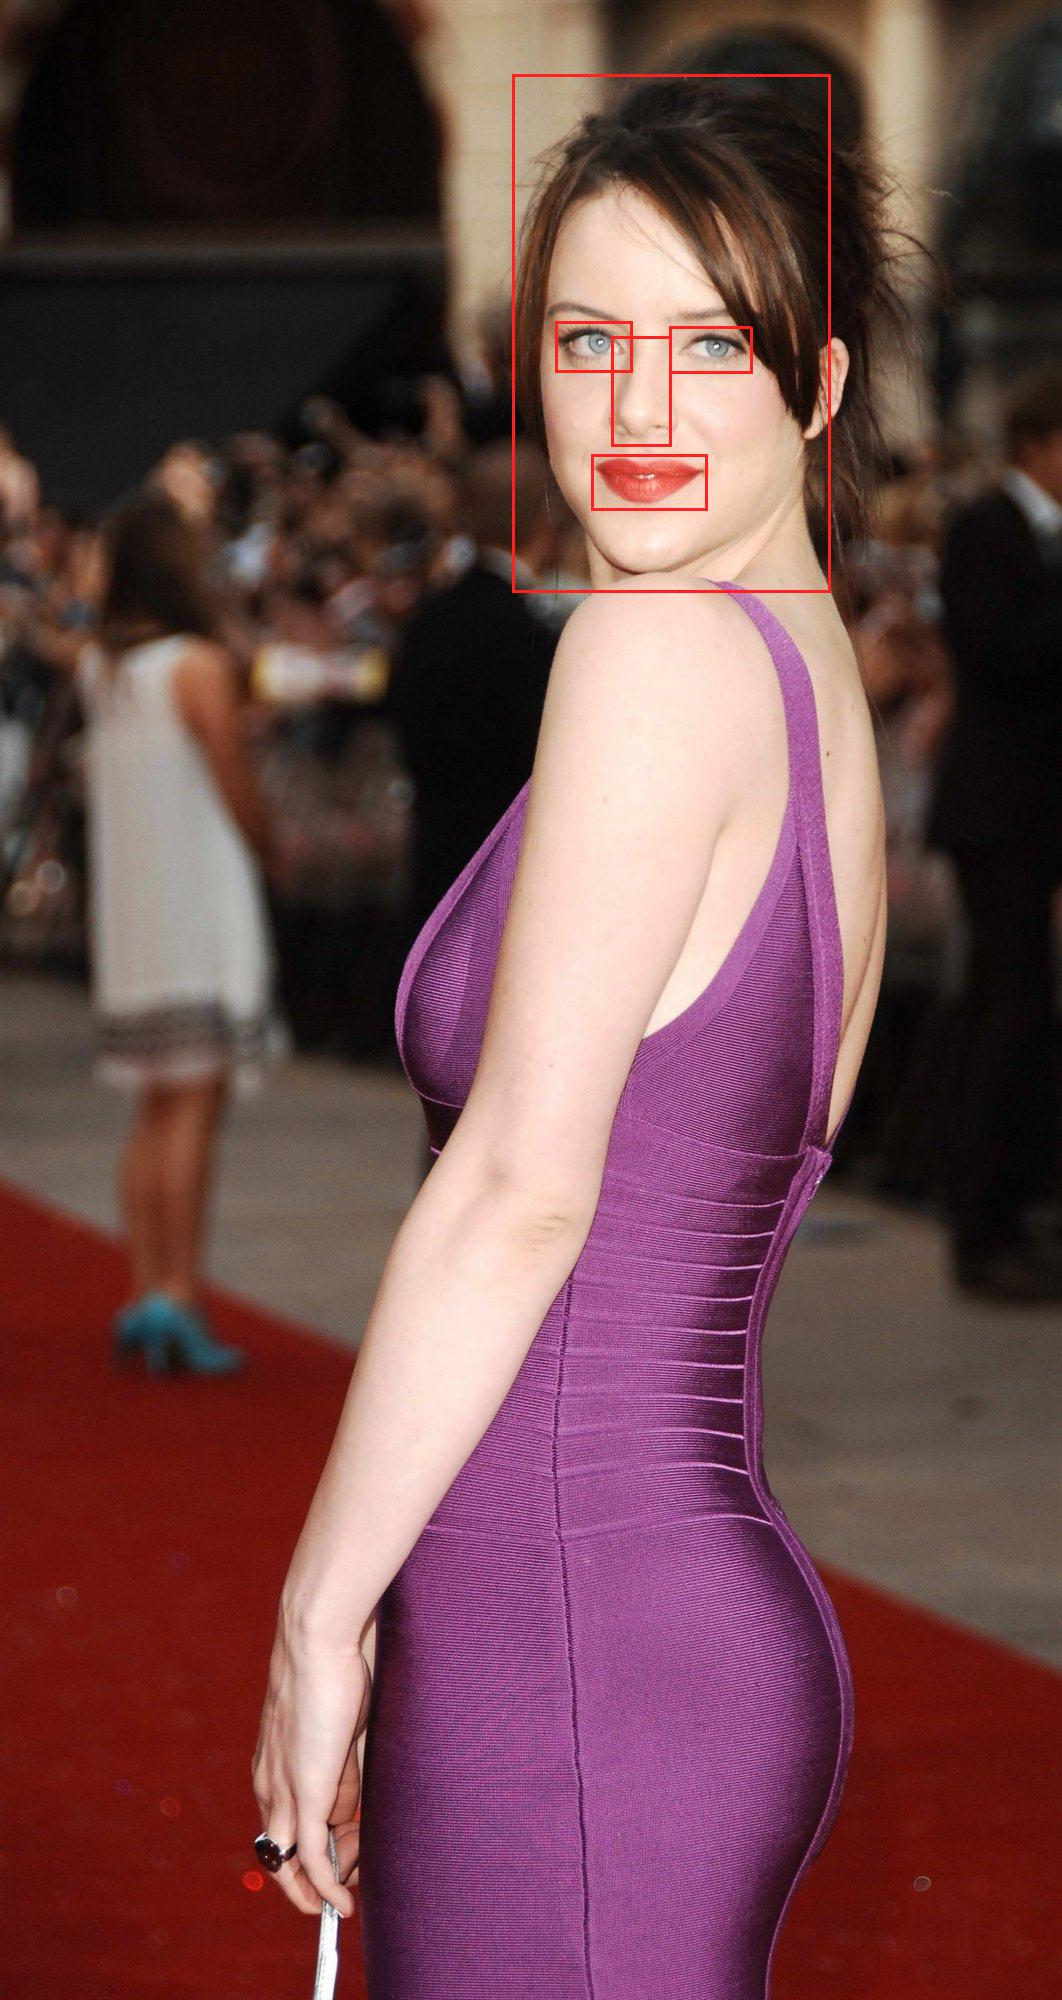

In [230]:
showImage(face_dict, '202599', '200034.jpg')